In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from collections import Counter
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import _stop_words
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import sent_tokenize


c:\Users\Lenovo\Documents\S2\NLP\Tubes-NLP-PaperMatch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Eksploarasi column-column dataset

In [2]:
ds = load_dataset("kilian-group/arxiv-classifier", "default")
train_df = ds["train"].to_pandas()

print("Distribution of 'field' column:")
print(train_df["field"].value_counts())

Distribution of 'field' column:
field
cs          27888
math        23195
physics     16645
cond-mat     7196
q-bio        6259
astro-ph     5587
q-fin        4604
nlin         3500
stat         3200
eess         2997
math-ph       800
hep-ex        800
hep-th        800
hep-lat       800
gr-qc         800
nucl-th       800
quant-ph      799
nucl-ex       799
hep-ph        798
econ          429
Name: count, dtype: int64


In [3]:
# Distribution primary subfield
train_df['primary_subfield'].value_counts(dropna=False).reset_index().rename(columns={'index': 'primary_subfield', 'primary_subfield': 'count'})

,count,count
0,math.FA,800
1,math-ph,800
2,physics.bio-ph,800
3,cs.DS,800
4,math.OA,800
...,...,...
140,econ.EM,331
141,nlin.CG,302
142,cs.OS,221
143,econ.TH,98


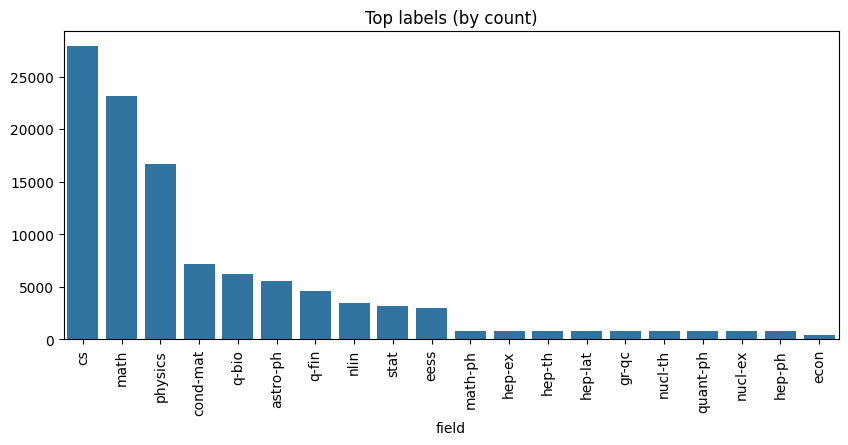

Imbalance ratio (max/min): 65.01


In [4]:
# bar chart of top labels
vc = train_df['field'].value_counts()

plt.figure(figsize=(10,4))
sns.barplot(x=vc.index[:30], y=vc.values[:30])
plt.xticks(rotation=90)
plt.title('Top labels (by count)')
plt.show()

# imbalance ratio (majority/minority)
if len(vc) > 1:
    imbalance = vc.max() / vc.min()
    print(f'Imbalance ratio (max/min): {imbalance:.2f}')

In [5]:
# Missing values
print('\nMissing values per column:')
print(train_df.isnull().sum())


Missing values per column:
paper_id              0
version               0
yymm                  0
created               0
title                 0
secondary_subfield    0
abstract              0
primary_subfield      0
field                 0
fulltext              0
dtype: int64


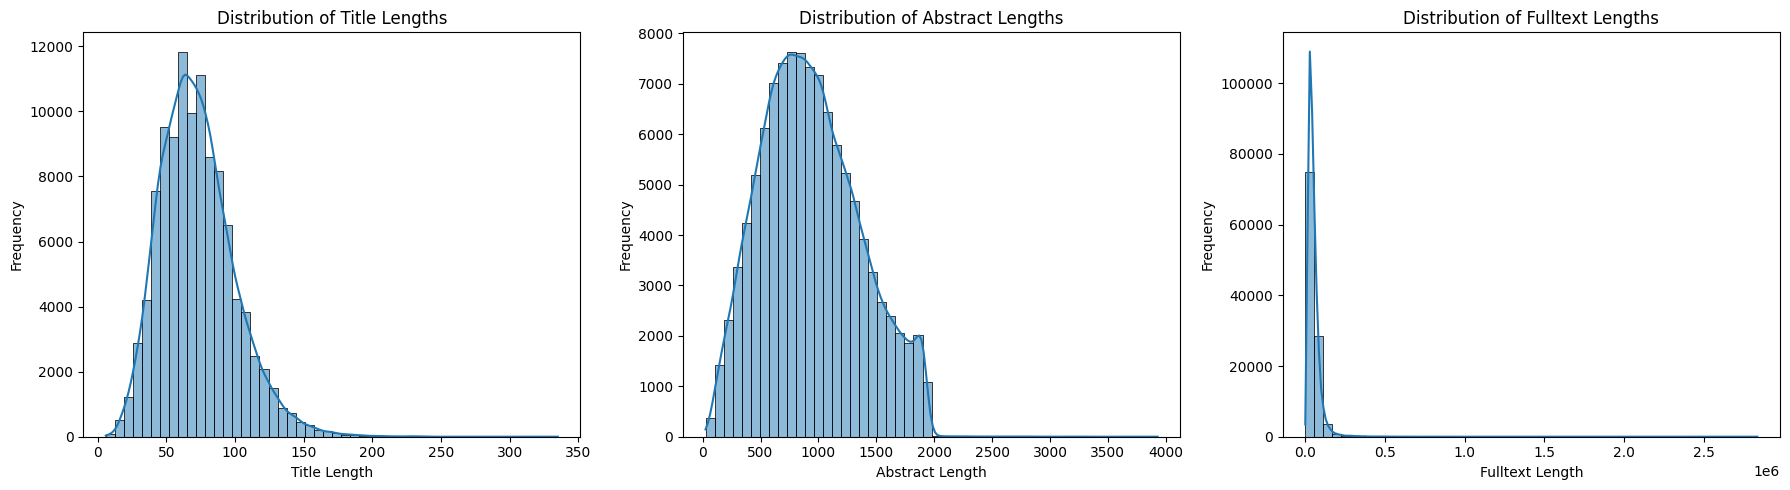

In [6]:
train_df['title_length'] = train_df['title'].apply(len)
train_df['abstract_length'] = train_df['abstract'].apply(len)
train_df['fulltext_length'] = train_df['fulltext'].apply(len)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_df['title_length'], bins=50, kde=True)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(train_df['abstract_length'], bins=50, kde=True)
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Abstract Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(train_df['fulltext_length'], bins=50, kde=True)
plt.title('Distribution of Fulltext Lengths')
plt.xlabel('Fulltext Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
print("Train shape:", train_df.shape)
display(train_df.head())

print("\nDtypes:")
print(train_df.dtypes)

Train shape: (108696, 13)


,paper_id,version,yymm,created,title,secondary_subfield,abstract,primary_subfield,field,fulltext,title_length,abstract_length,fulltext_length
0,1501.03486,2,1501,2015-01-16 10:15:42,A spin-wave logic gate based on a width-modula...,[cond-mat.mes-hall],An electric current controlled spin-wave logic...,cond-mat.mes-hall,cond-mat,A spin-wave logic gate based on a width-modula...,74,530,17894
1,0908.4485,2,0908,2010-03-15 10:35:23,Discontinuous Euler instability in nanoelectro...,[cond-mat.mes-hall],We investigate nanoelectromechanical systems n...,cond-mat.mes-hall,cond-mat,\nDiscontinuous Euler instability in nanoelect...,64,573,20668
2,1007.3144,1,1007,2010-07-19 13:24:01,Polarization dependence of coherent phonon gen...,[cond-mat.mes-hall],We have investigated the polarization dependen...,cond-mat.mes-hall,cond-mat,\nPolarization dependence of coherent phonon g...,116,1308,38265
3,1607.04802,2,1607,2016-09-07 10:45:25,Heat production and error probability relation...,"[cond-mat.mes-hall, cond-mat.stat-mech]",The erasure of a classical bit of information ...,cond-mat.mes-hall,cond-mat,\nHeat production and error probability relati...,89,967,26188
4,1109.0619,1,1109,2011-09-03 13:19:56,Magnetic Fields Effects on the Electronic Cond...,[cond-mat.mes-hall],While mesoscopic conducting loops are sensitiv...,cond-mat.mes-hall,cond-mat,Magnetic Fields Effects on the Electronic Cond...,92,1865,91442



Dtypes:
paper_id                     object
version                      object
yymm                         object
created               datetime64[s]
title                        object
secondary_subfield           object
abstract                     object
primary_subfield             object
field                        object
fulltext                     object
title_length                  int64
abstract_length               int64
fulltext_length               int64
dtype: object


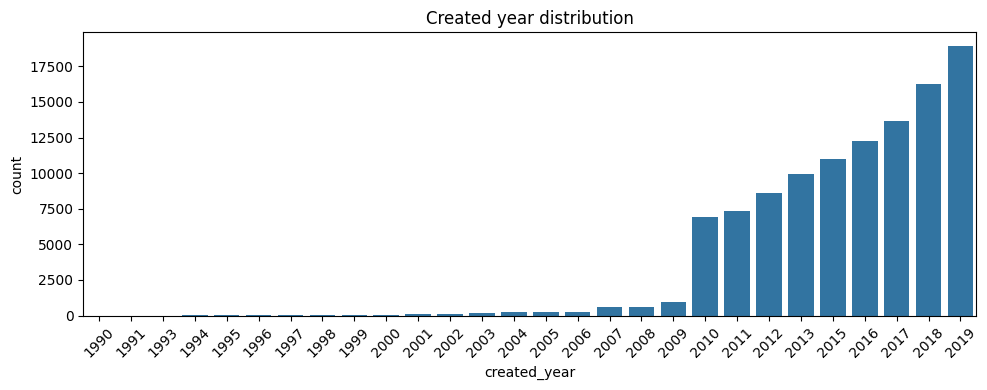

In [8]:
# Distribusi tahun publish
if "created" in train_df.columns:
    train_df["created_dt"] = pd.to_datetime(train_df["created"], errors="coerce")
    if train_df["created_dt"].notna().any():
        train_df["created_year"] = train_df["created_dt"].dt.year
        plt.figure(figsize=(10,4))
        sns.countplot(x="created_year", data=train_df)
        plt.title("Created year distribution")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid parsed datetimes in 'created' column.")

### Eksplorasi token abstract

In [9]:
STOPWORDS = set(list(_stop_words.ENGLISH_STOP_WORDS))

def tokenize(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    toks = [t for t in text.split() if t and t not in STOPWORDS and len(t) > 2]
    return toks

# apply to abstracts
train_df['abstract_tokens'] = train_df['abstract'].fillna("").astype(str).apply(tokenize)
train_df['abstract_token_count'] = train_df['abstract_tokens'].apply(len)
print('Abstract tokens - median, mean, std:', train_df['abstract_token_count'].median(), train_df['abstract_token_count'].mean(), train_df['abstract_token_count'].std())

Abstract tokens - median, mean, std: 76.0 79.7478564068595 36.89707625504236


In [10]:
# top unigrams overall
all_tokens = Counter()
for toks in train_df['abstract_tokens']:
    all_tokens.update(toks)
print('\nTop 25 unigrams overall:')
print(all_tokens.most_common(25))


Top 25 unigrams overall:
[('model', 49938), ('data', 40671), ('based', 36770), ('results', 36559), ('using', 35621), ('time', 35498), ('paper', 33635), ('method', 25950), ('study', 24846), ('problem', 24096), ('new', 23418), ('models', 22136), ('different', 22011), ('used', 21780), ('systems', 21557), ('present', 20327), ('approach', 20307), ('non', 20210), ('number', 19796), ('high', 19548), ('analysis', 18983), ('energy', 18974), ('order', 18801), ('field', 18770), ('network', 18635)]


In [33]:
# top unigrams per top 5 fields
if 'field' in train_df.columns:
    top_fields = train_df['field'].value_counts().index[:5]
    for f in top_fields:
        c = Counter()
        for toks in train_df[train_df['field']==f]['abstract_tokens']:
            c.update(toks)
        print(f"\nTop 15 unigrams for field {f}:")
        print(c.most_common(15))
    bot_fields = train_df['field'].value_counts().index[-5:]
    for f in bot_fields:
        c = Counter()
        for toks in train_df[train_df['field']==f]['abstract_tokens']:
            c.update(toks)
        print(f"\nTop 15 unigrams for field {f}:")
        print(c.most_common(15))


Top 15 unigrams for field cs:
[('data', 17029), ('based', 15947), ('paper', 14613), ('model', 12842), ('time', 12194), ('problem', 11604), ('using', 11143), ('algorithm', 10931), ('results', 10362), ('network', 9101), ('performance', 8875), ('proposed', 8480), ('approach', 8275), ('systems', 8050), ('method', 8021)]

Top 15 unigrams for field math:
[('paper', 7447), ('prove', 6837), ('space', 6486), ('group', 6282), ('results', 5979), ('mathbb', 5875), ('theory', 5236), ('finite', 5164), ('algebra', 5154), ('study', 5122), ('mathcal', 4560), ('non', 4438), ('set', 4306), ('groups', 4305), ('spaces', 4282)]

Top 15 unigrams for field physics:
[('model', 7535), ('time', 6385), ('using', 6192), ('energy', 5872), ('results', 5603), ('field', 5503), ('based', 5378), ('data', 5030), ('method', 4769), ('high', 4757), ('used', 4244), ('different', 3906), ('study', 3649), ('electron', 3408), ('present', 3401)]

Top 15 unigrams for field cond-mat:
[('spin', 4026), ('phase', 3715), ('model', 354

In [12]:
# bigrams (simple implementation)
bigram_counts = Counter()
for toks in train_df['abstract_tokens']:
    bigrams = (" ".join(pair) for pair in zip(toks, toks[1:]))
    bigram_counts.update(bigrams)
print('\nTop 25 bigrams overall:')
print(bigram_counts.most_common(25))


Top 25 bigrams overall:
[('state art', 3935), ('magnetic field', 3009), ('monte carlo', 2911), ('large scale', 2706), ('neural network', 2585), ('machine learning', 2479), ('neural networks', 2355), ('paper propose', 2285), ('real world', 2228), ('experimental results', 2191), ('time series', 2089), ('real time', 2079), ('proposed method', 1947), ('paper present', 1906), ('paper presents', 1845), ('deep learning', 1747), ('power law', 1687), ('numerical simulations', 1550), ('wide range', 1481), ('differential equations', 1450), ('paper study', 1401), ('second order', 1361), ('experimental data', 1313), ('ground state', 1303), ('phase transition', 1294)]



Top 15 bigrams for field cs:
[('state art', 2729), ('real world', 1576), ('neural networks', 1509), ('neural network', 1492), ('paper propose', 1478), ('machine learning', 1369), ('real time', 1329), ('experimental results', 1244), ('paper presents', 1169), ('paper present', 1157), ('large scale', 1068), ('deep learning', 1005), ('polynomial time', 950), ('proposed method', 913), ('propose novel', 729)]

Top 15 bigrams for field math:
[('finite dimensional', 689), ('paper study', 606), ('mathbb mathbb', 582), ('lie algebra', 527), ('main result', 506), ('sufficient conditions', 487), ('finitely generated', 462), ('mathcal mathcal', 461), ('differential equations', 460), ('lie algebras', 428), ('necessary sufficient', 379), ('paper prove', 362), ('non trivial', 349), ('fixed point', 342), ('second order', 330)]

Top 15 bigrams for field physics:
[('magnetic field', 1292), ('solar wind', 673), ('monte carlo', 620), ('numerical simulations', 504), ('electric field', 497), ('large scale',

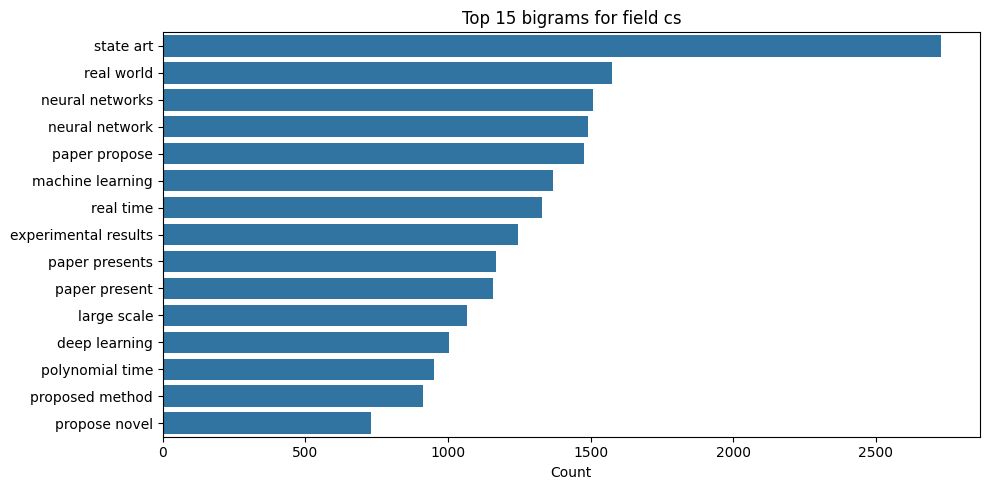

In [ ]:
# Top bigrams per top 5 fields
from itertools import tee

def bigrams_from_tokens(tokens):
    return [' '.join(pair) for pair in zip(tokens, tokens[1:])]

if 'field' in train_df.columns:
    top_fields = train_df['field'].value_counts().index[:5]
    for f in top_fields:
        bigram_c = Counter()
        for toks in train_df[train_df['field']==f]['abstract_tokens']:
            bigram_c.update(bigrams_from_tokens(toks))
        print(f"\nTop 15 bigrams for field {f}:")
        print(bigram_c.most_common(15))

# Plotting top bigrams for first field as a bar chart
if 'field' in train_df.columns:
    first_f = top_fields[0]
    bigram_c = Counter()
    for toks in train_df[train_df['field']==first_f]['abstract_tokens']:
        bigram_c.update(bigrams_from_tokens(toks))
    top = bigram_c.most_common(15)
    if top:
        labels, vals = zip(*top)
        plt.figure(figsize=(10,5))
        sns.barplot(x=list(vals), y=list(labels))
        plt.title(f'Top 15 bigrams for field {first_f}')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.show()S

In [14]:
all_toks = Counter()
all_tris = Counter()
for toks in train_df['abstract_tokens']:
    all_toks.update(toks)
    all_tris.update([' '.join(tri) for tri in zip(toks, toks[1:], toks[2:])])
print('\nTop 30 tokens:')
print(all_toks.most_common(30))
print('\nTop 20 trigrams:')
print(all_tris.most_common(20))


Top 30 tokens:
[('model', 49938), ('data', 40671), ('based', 36770), ('results', 36559), ('using', 35621), ('time', 35498), ('paper', 33635), ('method', 25950), ('study', 24846), ('problem', 24096), ('new', 23418), ('models', 22136), ('different', 22011), ('used', 21780), ('systems', 21557), ('present', 20327), ('approach', 20307), ('non', 20210), ('number', 19796), ('high', 19548), ('analysis', 18983), ('energy', 18974), ('order', 18801), ('field', 18770), ('network', 18635), ('algorithm', 18242), ('state', 18034), ('proposed', 18022), ('large', 17889), ('space', 17622)]

Top 20 trigrams:
[('monte carlo simulations', 621), ('density functional theory', 587), ('convolutional neural network', 523), ('deep neural networks', 479), ('partial differential equations', 426), ('convolutional neural networks', 425), ('signal noise ratio', 415), ('state art methods', 384), ('markov chain monte', 382), ('chain monte carlo', 382), ('deep neural network', 366), ('paper propose novel', 346), ('play

In [15]:
# Basic text length stats (words + chars)
for col in ['title','abstract','fulltext']:
    if col in train_df.columns:
        train_df[f'{col}_chars'] = train_df[col].fillna('').astype(str).apply(len)
        train_df[f'{col}_words'] = train_df[col].fillna('').astype(str).apply(lambda x: len(x.split()))

print('\nText length stats (abstract):')
if 'abstract_words' in train_df.columns:
    print(train_df['abstract_words'].describe(percentiles=[0.25,0.5,0.75,0.95]))


Text length stats (abstract):
count    108696.000000
mean        139.443779
std          63.297790
min           4.000000
25%          92.000000
50%         134.000000
75%         182.000000
95%         255.000000
max         552.000000
Name: abstract_words, dtype: float64


In [16]:
STOPWORDS = set(list(_stop_words.ENGLISH_STOP_WORDS))

def cleaning_metrics(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {"chars":0, "tokens":0, "stopword_ratio":0.0, "punct_ratio":0.0, "digit_ratio":0.0}
    chars = len(text)
    tokens = [t for t in re.findall(r"\w+", text.lower())]
    if len(tokens)==0:
        sw_ratio = 0.0
    else:
        sw_ratio = sum(1 for t in tokens if t in STOPWORDS) / len(tokens)
    punct_ratio = sum(1 for ch in text if ch in string.punctuation) / max(chars,1)
    digit_ratio = sum(1 for ch in text if ch.isdigit()) / max(chars,1)
    return {"chars":chars, "tokens":len(tokens), "stopword_ratio":sw_ratio, "punct_ratio":punct_ratio, "digit_ratio":digit_ratio}

metrics = train_df['abstract'].fillna('').astype(str).apply(cleaning_metrics)
metrics_df = pd.DataFrame(list(metrics))
train_df = pd.concat([train_df.reset_index(drop=True), metrics_df.reset_index(drop=True)], axis=1)

print('Abstract cleaning metrics (median):')
print(metrics_df.median())

Abstract cleaning metrics (median):
chars             901.000000
tokens            140.000000
stopword_ratio      0.414634
punct_ratio         0.022599
digit_ratio         0.000000
dtype: float64


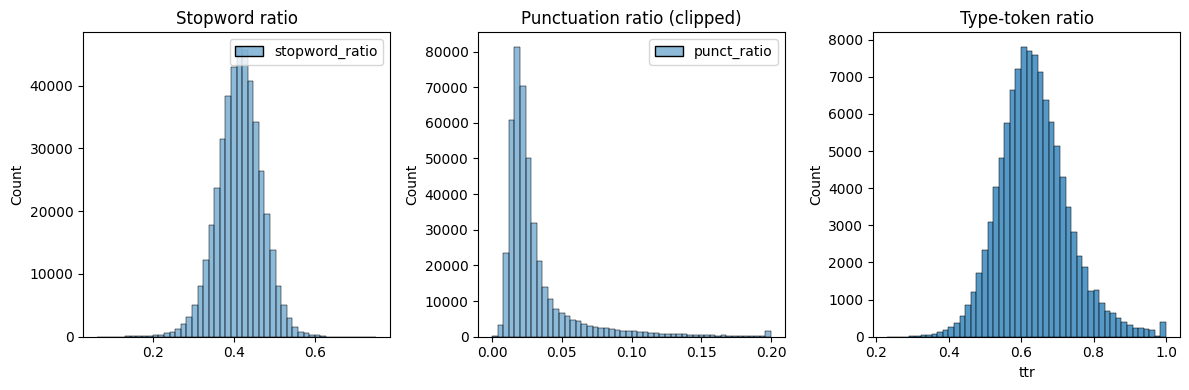

In [17]:
def text_quality_metrics(text):
    t = str(text)
    tokens = re.findall(r"\w+", t.lower())
    if len(tokens) == 0:
        return {'stopword_ratio':0.0, 'punct_ratio':0.0, 'ttr':0.0}
    sw_ratio = sum(1 for w in tokens if w in STOPWORDS) / len(tokens)
    punct_ratio = sum(1 for ch in t if ch in string.punctuation) / max(len(t),1)
    ttr = len(set(tokens)) / len(tokens)
    return {'stopword_ratio':sw_ratio, 'punct_ratio':punct_ratio, 'ttr':ttr}

metrics = train_df['abstract'].fillna('').astype(str).apply(text_quality_metrics)
metrics_df = pd.DataFrame(list(metrics))
train_df = pd.concat([train_df.reset_index(drop=True), metrics_df.reset_index(drop=True)], axis=1)

# distributions
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(train_df['stopword_ratio'].clip(0,1), bins=50)
plt.title('Stopword ratio')
plt.subplot(1,3,2)
sns.histplot(train_df['punct_ratio'].clip(0,0.2), bins=50)
plt.title('Punctuation ratio (clipped)')
plt.subplot(1,3,3)
sns.histplot(train_df['ttr'].clip(0,1), bins=50)
plt.title('Type-token ratio')
plt.tight_layout()
plt.show()

In [18]:
# identify outliers in fulltext length (extremely long documents)
if 'fulltext_length' not in train_df.columns:
    train_df['fulltext_length'] = train_df['fulltext'].fillna('').astype(str).apply(len)

q99 = train_df['fulltext_length'].quantile(0.99)
print(f"99th percentile of fulltext length: {q99}")
print('Number of docs above 99th percentile:', (train_df['fulltext_length'] > q99).sum())

99th percentile of fulltext length: 202733.35000000003
Number of docs above 99th percentile: 1087


In [19]:
dup_count = train_df.duplicated(subset=['title','abstract','fulltext']).sum()
print(f"\nDuplicate rows by title+abstract+fulltext: {dup_count}")


Duplicate rows by title+abstract+fulltext: 2


In [20]:
# Remove empty text rows (where abstract or title empty)
initial_len = len(train_df)
train_df = train_df[~(train_df['abstract'].fillna('').str.strip() == '')]
train_df = train_df.drop_duplicates(subset=['title','abstract','fulltext'])
print('Rows removed (empty or duplicate):', initial_len - len(train_df))

Rows removed (empty or duplicate): 2


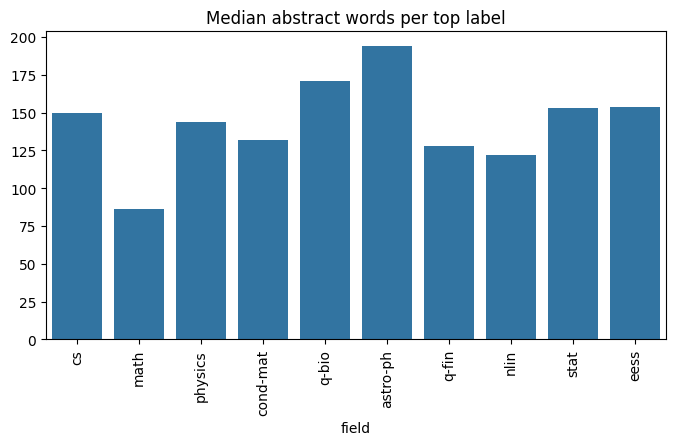

In [21]:
# average abstract length per label (top 10 labels)
if 'abstract_words' in train_df.columns:
    top_labels = vc.index[:10]
    avg_len = train_df.groupby('field')['abstract_words'].median().loc[top_labels]
    plt.figure(figsize=(8,4))
    sns.barplot(x=avg_len.index, y=avg_len.values)
    plt.xticks(rotation=90)
    plt.title('Median abstract words per top label')
    plt.show()

### Eksplorasi makna semantik abstract

Batches: 100%|██████████| 32/32 [01:03<00:00,  1.99s/it]


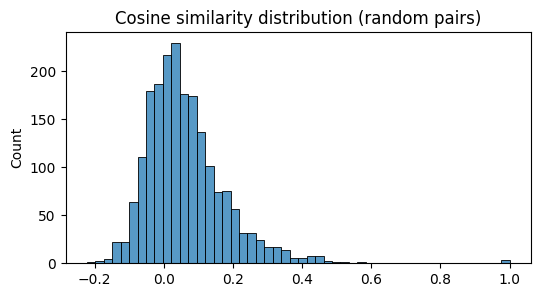

Number of near-duplicate pairs (sim>0.95): 0


In [22]:
# sample texts to embed
sample_n = min(2000, len(train_df))
sample_df = train_df.sample(n=sample_n, random_state=42)
texts = sample_df['abstract'].fillna('').astype(str).tolist()

# load model and embed
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
emb = model.encode(texts, show_progress_bar=True, batch_size=64)

# cosine similarity distribution (sample random pairs)
rng = np.random.default_rng(42)
pairs = rng.choice(sample_n, size=(2000,2))
sims = [cosine_similarity([emb[i]],[emb[j]])[0,0] for i,j in pairs]

plt.figure(figsize=(6,3))
sns.histplot(sims, bins=50)
plt.title('Cosine similarity distribution (random pairs)')
plt.show()

# near-duplicates >0.95
sim_mat = cosine_similarity(emb)
np.fill_diagonal(sim_mat, -1)
near_dup_pairs = np.argwhere(sim_mat > 0.95)
print('Number of near-duplicate pairs (sim>0.95):', len(near_dup_pairs))

c:\Users\Lenovo\Documents\S2\NLP\Tubes-NLP-PaperMatch\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


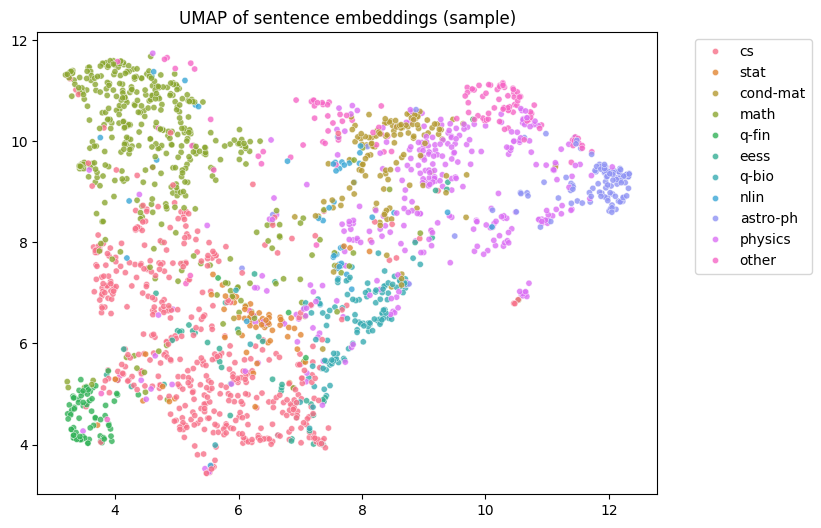

In [23]:
# 2D UMAP projection
reducer = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
emb2 = reducer.fit_transform(emb)

plt.figure(figsize=(8,6))
if 'field' in sample_df.columns:
    sns.scatterplot(x=emb2[:,0], y=emb2[:,1], hue=sample_df['field'].where(sample_df['field'].isin(sample_df['field'].value_counts().index[:10]), 'other'), s=20, alpha=0.8)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
else:
    plt.scatter(emb2[:,0], emb2[:,1], s=10)
plt.title('UMAP of sentence embeddings (sample)')
plt.show()

In [24]:
import plotly.express as px

# --- BAGIAN 1: DATA PREPARATION ---
# Pastikan tidak ada missing values di kolom relevan untuk visualisasi
df_clean = train_df.dropna(subset=['field', 'primary_subfield']).copy()

# Hitung jumlah paper per kombinasi Field -> Subfield
hierarchy_counts = df_clean.groupby(['field', 'primary_subfield']).size().reset_index(name='count')

# --- BAGIAN 2: VISUALISASI SUNBURST (INTERAKTIF) ---
# Sunburst chart sangat bagus untuk melihat proporsi hierarki
print("Membuat Sunburst Chart...")

fig = px.sunburst(
    hierarchy_counts,
    path=['field', 'primary_subfield'], # Urutan hierarki: Dalam (Field) -> Luar (Subfield)
    values='count',
    title='Hierarki Distribusi: Field vs. Subfield',
    width=800,
    height=800
)

# Menampilkan angka/persentase saat hover
fig.update_traces(textinfo="label+percent entry")
fig.show()

# --- BAGIAN 3: ANALISIS OVERLAP (APAKAH SUBFIELD UNIK?) ---
# Mengecek apakah ada subfield yang muncul di lebih dari satu Field utama
subfield_owners = df_clean.groupby('primary_subfield')['field'].nunique()
shared_subfields = subfield_owners[subfield_owners > 1]

Membuat Sunburst Chart...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_37404\2549887172.py:53: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_37404\2549887172.py:60: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_37404\2549887172.py:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




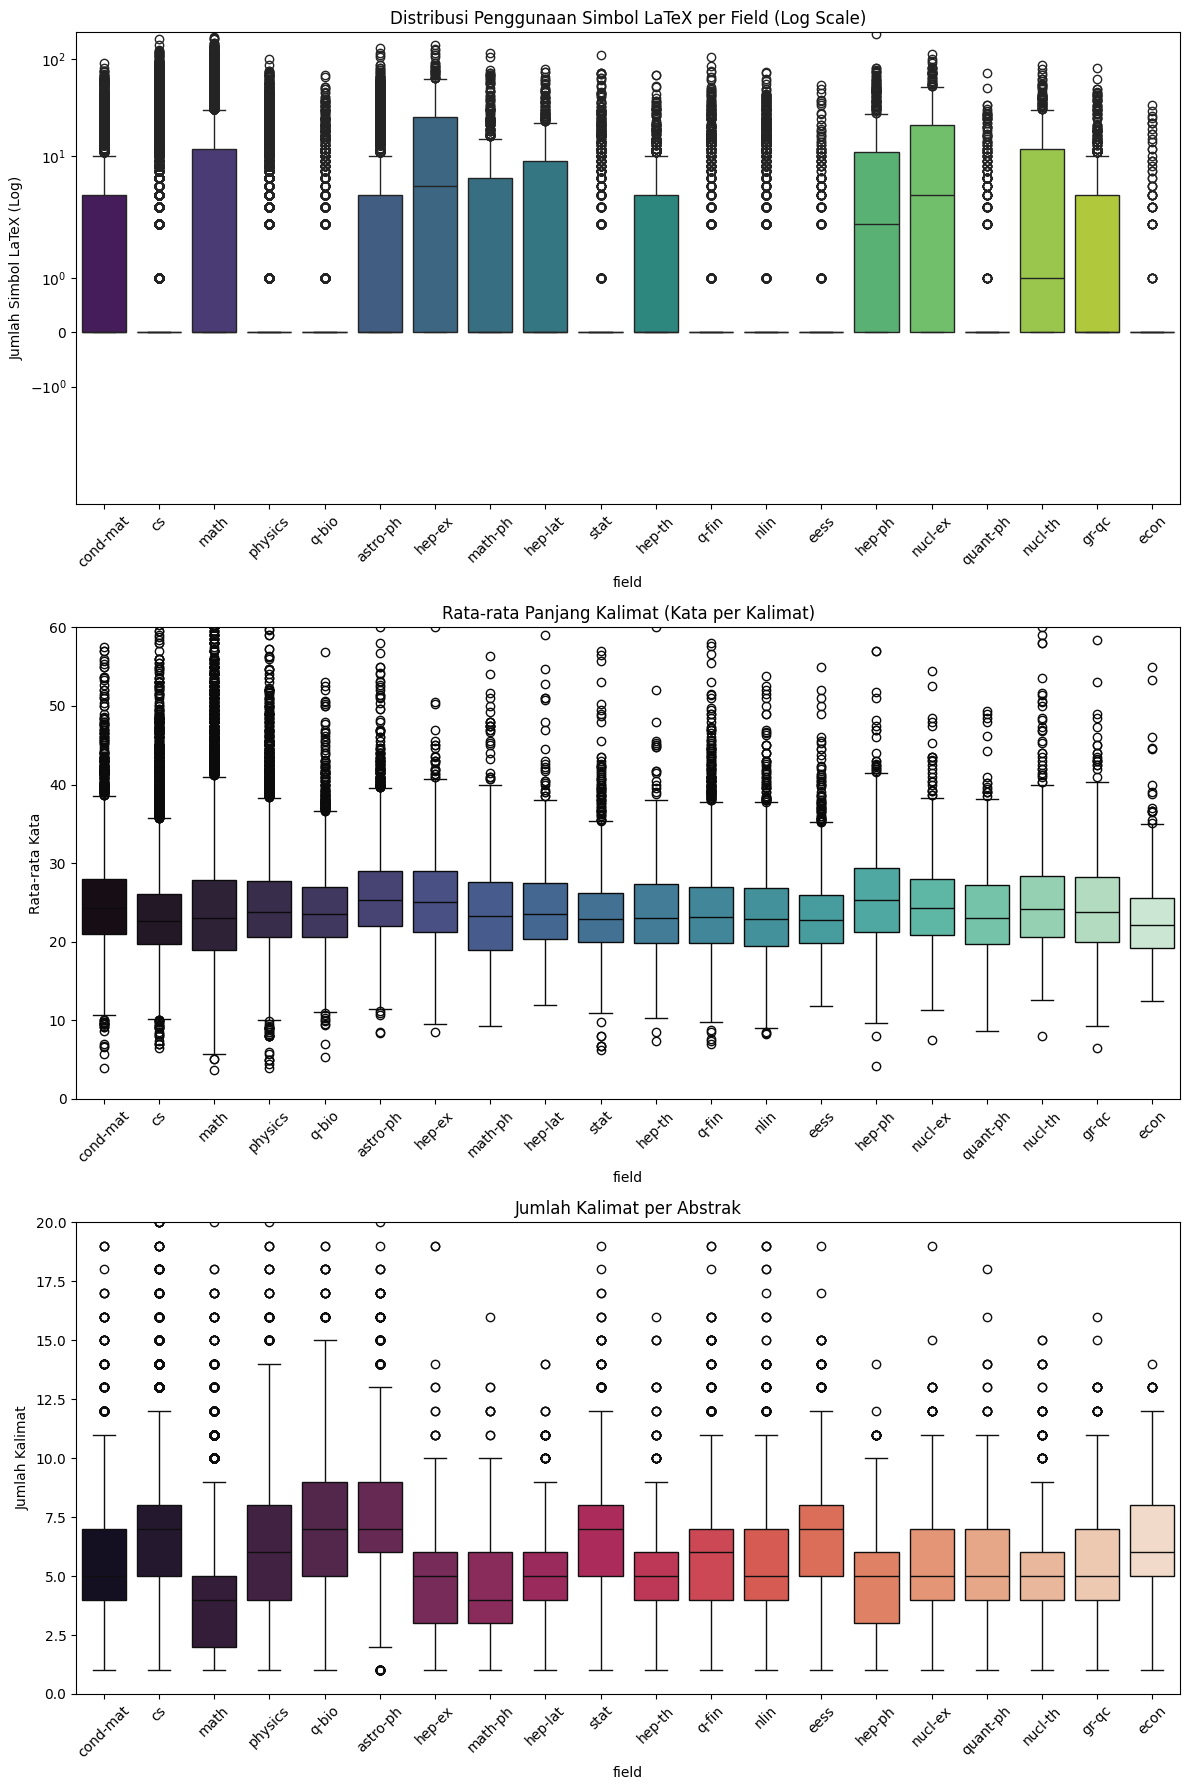

In [25]:
# Download tokenizer kalimat jika belum ada
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab') # Versi nltk terbaru kadang butuh ini

# --- 1. FUNGSI EKSTRAKSI FITUR ---

def count_latex_symbols(text):
    """Menghitung kemunculan simbol matematika ($...$) atau command LaTeX umum"""
    if not isinstance(text, str): return 0
    # Hitung simbol dollar ($) yang lazim untuk rumus inline
    dollar_count = text.count('$')
    # Hitung pola backslash umum (\frac, \sum, \alpha, dll)
    latex_pattern = r'\\[a-zA-Z]+' 
    latex_cmds = len(re.findall(latex_pattern, text))
    return dollar_count + latex_cmds

def get_sentence_stats(text):
    """Mengembalikan jumlah kalimat dan rata-rata panjang kalimat (kata)"""
    if not isinstance(text, str): return 0, 0
    sentences = sent_tokenize(text)
    num_sentences = len(sentences)
    
    if num_sentences == 0:
        return 0, 0
    
    # Hitung kata per kalimat
    words_per_sent = [len(s.split()) for s in sentences]
    avg_len = np.mean(words_per_sent)
    return num_sentences, avg_len

# --- 2. TERAPKAN KE DATAFRAME ---

# Kita gunakan copy agar tidak merusak df asli
df_structure = train_df.copy()

# Terapkan fungsi (ini mungkin butuh waktu 1-2 menit jika data besar)
df_structure['latex_count'] = df_structure['abstract'].apply(count_latex_symbols)
temp_stats = df_structure['abstract'].apply(get_sentence_stats)

# Pecah tuple hasil (num_sentences, avg_len) ke kolom terpisah
df_structure['sentence_count'] = temp_stats.apply(lambda x: x[0])
df_structure['avg_sent_len'] = temp_stats.apply(lambda x: x[1])

# --- 3. VISUALISASI ---

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot A: Densitas LaTeX per Field
# Kita pakai log scale karena variansinya bisa sangat besar (0 vs 100 simbol)
sns.boxplot(x='field', y='latex_count', data=df_structure, ax=axes[0], palette='viridis')
axes[0].set_yscale('symlog') # Menggunakan skala logaritmik agar outlier terlihat jelas
axes[0].set_title('Distribusi Penggunaan Simbol LaTeX per Field (Log Scale)')
axes[0].set_ylabel('Jumlah Simbol LaTeX (Log)')
axes[0].tick_params(axis='x', rotation=45)

# Plot B: Rata-rata Panjang Kalimat
sns.boxplot(x='field', y='avg_sent_len', data=df_structure, ax=axes[1], palette='mako')
axes[1].set_title('Rata-rata Panjang Kalimat (Kata per Kalimat)')
axes[1].set_ylabel('Rata-rata Kata')
axes[1].tick_params(axis='x', rotation=45)
# Zoom in sedikit agar tidak terganggu outlier ekstrim
axes[1].set_ylim(0, 60) 

# Plot C: Jumlah Kalimat per Abstrak
sns.boxplot(x='field', y='sentence_count', data=df_structure, ax=axes[2], palette='rocket')
axes[2].set_title('Jumlah Kalimat per Abstrak')
axes[2].set_ylabel('Jumlah Kalimat')
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0, 20)

plt.tight_layout()
plt.show()

In [26]:
# --- 4. STATISTIK RINGKASAN ---
print("\nRata-rata Penggunaan LaTeX per Field:")
print(df_structure.groupby('field')['latex_count'].mean().sort_values(ascending=False))


Rata-rata Penggunaan LaTeX per Field:
field
hep-ex      15.758750
nucl-ex     13.026283
math         9.724251
hep-ph       8.793233
nucl-th      7.752500
hep-lat      6.615000
math-ph      5.750000
astro-ph     4.943082
gr-qc        4.093750
cond-mat     4.083519
hep-th       3.978750
cs           2.504680
nlin         2.159714
quant-ph     2.017522
physics      2.006309
stat         1.570938
q-fin        1.226977
econ         1.027972
q-bio        0.818981
eess         0.449783
Name: latex_count, dtype: float64



Topik yang ditemukan:
Topic #0: stars, type, mathrm, protein, sequence, galaxies, star, properties, game, maps
Topic #1: data, based, model, paper, network, using, performance, proposed, information, approach
Topic #2: data, 10, high, mass, using, energy, results, measurements, ray, low
Topic #3: space, group, prove, algebra, paper, mathbb, finite, theory, groups, mathcal
Topic #4: method, model, equation, function, equations, linear, matrix, order, numerical, approach
Topic #5: problem, algorithm, time, number, graph, optimal, graphs, algorithms, paper, set
Topic #6: field, model, energy, phase, dynamics, quantum, state, magnetic, states, time



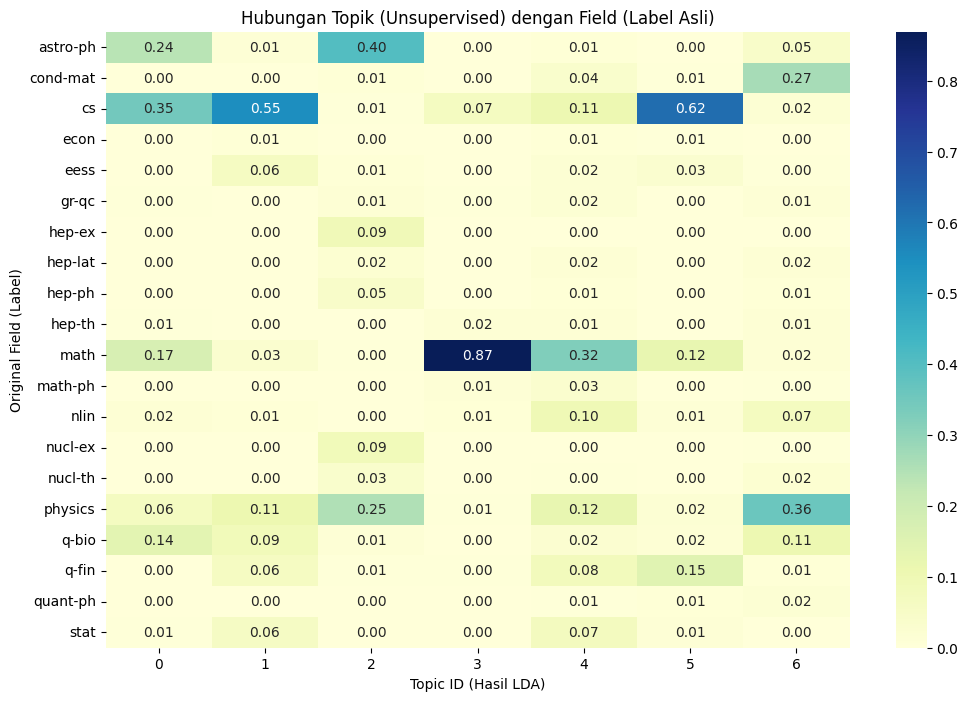

In [27]:
# --- 1. PERSIAPAN DATA ---
# LDA cukup berat komputasinya, kita gunakan sampel 20k-50k jika data > 100k
# Sesuaikan n=... dengan kemampuan RAM Anda
sample_size = 30000
if len(train_df) > sample_size:
    df_lda = train_df.sample(n=sample_size, random_state=42).copy()
else:
    df_lda = train_df.copy()

# Bersihkan null
df_lda = df_lda.dropna(subset=['abstract', 'field'])

# --- 2. VEKTORISASI (Bag of Words) ---
# LDA bekerja dengan hitungan kata (Count), bukan TF-IDF
tf_vectorizer = CountVectorizer(
    max_df=0.95,      # Abaikan kata yang muncul di > 95% dokumen (terlalu umum)
    min_df=2,         # Abaikan kata yang muncul < 2 kali
    max_features=5000,# Ambil 5000 kata teratas saja
    stop_words='english'
)
tf = tf_vectorizer.fit_transform(df_lda['abstract'])

# --- 3. LATIH MODEL LDA ---
# Kita coba cari 7 topik (bisa disesuaikan dengan jumlah Field unik Anda)
n_topics = 7 

lda = LatentDirichletAllocation(
    n_components=n_topics, 
    max_iter=10, 
    learning_method='online', 
    random_state=42,
    n_jobs=-1
)
lda.fit(tf)

# --- 4. MENAMPILKAN KATA KUNCI PER TOPIK ---
def print_top_words(model, feature_names, n_top_words):
    print("\nTopik yang ditemukan:")
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda, tf_vectorizer.get_feature_names_out(), 10)

# --- 5. ANALISIS HUBUNGAN: TOPIK VS FIELD ASLI ---
# Kita ingin tahu: Topic 0 itu sebenarnya Field apa?

# Dapatkan distribusi topik untuk setiap dokumen
topic_values = lda.transform(tf)
df_lda['dominant_topic'] = topic_values.argmax(axis=1)

# Buat Crosstab: Field vs Dominant Topic
topic_field_matrix = pd.crosstab(df_lda['field'], df_lda['dominant_topic'])

# Normalisasi per kolom (Topic) agar kita tahu: 
# "Jika dokumen masuk Topic 0, berapa % kemungkinannya dia Field X?"
topic_field_norm = topic_field_matrix.div(topic_field_matrix.sum(axis=0), axis=1)

# Visualisasi Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_field_norm, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Hubungan Topik (Unsupervised) dengan Field (Label Asli)')
plt.xlabel('Topic ID (Hasil LDA)')
plt.ylabel('Original Field (Label)')
plt.show()

In [28]:
# --- 1. PERSIAPAN DATA ---
# Gunakan sampel agar cepat (misal 20k - 30k)
sample_size = 50000
if len(train_df) > sample_size:
    print(f"Mengambil sampel {sample_size} baris...")
    df_overlap = train_df.sample(n=sample_size, random_state=42).copy()
else:
    df_overlap = train_df.copy()

# Pastikan data bersih
df_overlap = df_overlap.dropna(subset=['abstract', 'field'])
df_overlap = df_overlap[df_overlap['abstract'].str.len() > 50] # Hapus abstrak terlalu pendek

# --- 2. VEKTORISASI & CENTROID KELAS ---

# Kita gunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df_overlap['abstract'])

# Hitung Rata-rata Vektor (Centroid) untuk setiap Field
unique_fields = sorted(df_overlap['field'].unique())
centroid_vectors = []

for field in unique_fields:
    # Ambil indeks dokumen yang punya field ini
    indices = df_overlap.index[df_overlap['field'] == field].tolist()
    # Ambil posisi baris di matriks sparse X (karena index df mungkin acak)
    # Kita perlu reset index df sementara untuk mapping yang benar
    doc_indices = df_overlap.reset_index().index[df_overlap['field'] == field].tolist()
    
    # Hitung rata-rata (mean) vektor untuk kelas ini
    class_mean = X[doc_indices].mean(axis=0)
    centroid_vectors.append(np.asarray(class_mean).flatten())

centroid_matrix = np.array(centroid_vectors)

# --- 3. HITUNG KEDEKATAN DOKUMEN VS CENTROID ---
# Cosine similarity: Dokumen x Semua Centroid
# Hasilnya adalah matriks (n_samples, n_classes)
sim_matrix = cosine_similarity(X, centroid_matrix)

# Buat DataFrame hasil similarity
sim_df = pd.DataFrame(sim_matrix, columns=unique_fields, index=df_overlap.index)

# --- 4. ANALISIS "AMBIGUITY SCORE" ---
# Kita cari dokumen yang 'tersesat'

results = []
for idx, row in df_overlap.iterrows():
    true_label = row['field']
    
    # Skor similarity ke label asli
    score_true = sim_df.loc[idx, true_label]
    
    # Cari skor similarity ke label TERTINGGI (selain label asli)
    other_cols = [c for c in unique_fields if c != true_label]
    best_rival_label = sim_df.loc[idx, other_cols].idxmax()
    score_rival = sim_df.loc[idx, best_rival_label]
    
    # Margin: Seberapa aman dokumen ini?
    # Jika negatif, berarti dokumen ini lebih mirip kelas lain (secara rata-rata)
    margin = score_true - score_rival
    
    results.append({
        'title': row['title'],
        'true_label': true_label,
        'rival_label': best_rival_label,
        'score_true': score_true,
        'score_rival': score_rival,
        'margin': margin,
        'abstract_snippet': row['abstract'][:100] + "..."
    })

res_df = pd.DataFrame(results)

# --- 5. MENAMPILKAN HASIL ---

# A. Dokumen paling "Ambigu" (Margin paling negatif)
# Ini adalah dokumen yang menurut statistik "salah alamat"
print("\n" + "="*60)
print("TOP 5 DOKUMEN PALING AMBIGU (Potensi Multi-label / Noise)")
print("="*60)
pd.set_option('display.max_colwidth', 100)
ambiguous_docs = res_df.sort_values('margin').head(5)
display(ambiguous_docs[['title', 'true_label', 'rival_label', 'margin']])

Mengambil sampel 50000 baris...

TOP 5 DOKUMEN PALING AMBIGU (Potensi Multi-label / Noise)


,title,true_label,rival_label,margin
20492,Quantum Hyperdeterminants and Hyper-Pfaffians,math,quant-ph,-0.458124
9000,The linear and nonlinear Jaynes-Cummings model for the multiphoton transition,physics,quant-ph,-0.440012
32779,Optimality in Quantum Data Compression using Dynamical Entropy,cs,quant-ph,-0.407628
21863,The Third Life of Quantum Logic: Quantum Logic Inspired by Quantum Computing,math,quant-ph,-0.368443
20018,Open Bisimulation for Quantum Processes,cs,quant-ph,-0.359474


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_37404\4112535446.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




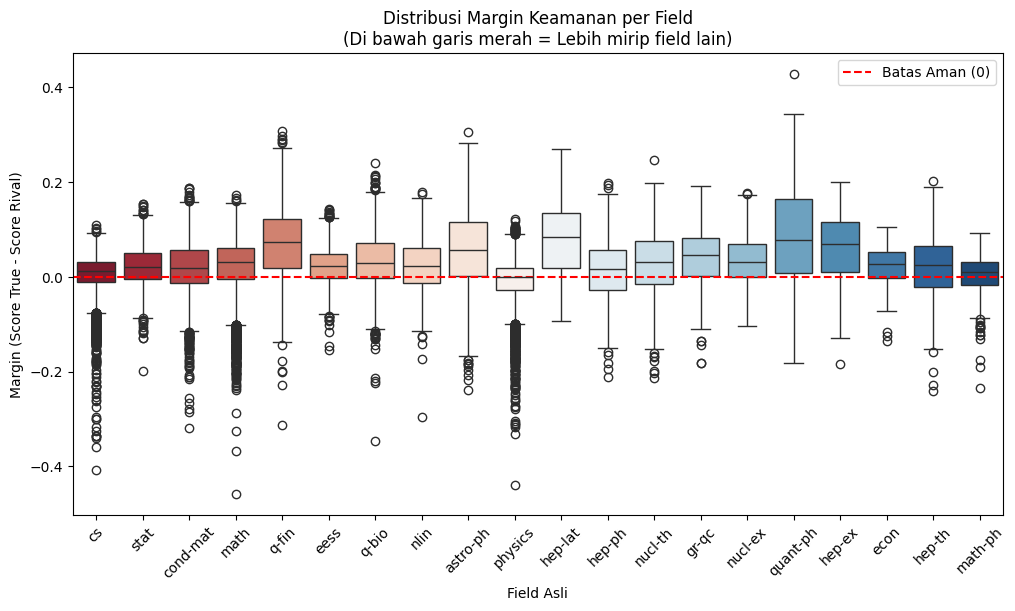

In [29]:
# B. Distribusi Margin per Field
# Field mana yang paling "tidak aman"?
plt.figure(figsize=(12, 6))
sns.boxplot(x='true_label', y='margin', data=res_df, palette='RdBu')
plt.axhline(0, color='red', linestyle='--', label='Batas Aman (0)')
plt.title('Distribusi Margin Keamanan per Field\n(Di bawah garis merah = Lebih mirip field lain)')
plt.ylabel('Margin (Score True - Score Rival)')
plt.xlabel('Field Asli')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# **Kesimpulan EDA Dataset ArXiv Classifier**

## 1. **Distribusi Label Sangat Tidak Seimbang**
Analisis kolom `field` menunjukkan ketimpangan kelas yang ekstrem:

- Rasio imbalance mencapai **±65:1**  
- Kelas mayoritas (mis. *computer science*) jauh lebih besar dibanding kelas minoritas.

**Implikasi untuk modeling:**
- Model sangat berpotensi bias ke kelas mayoritas.  
- Perlu penerapan teknik mitigasi seperti **class weighting, focal loss, oversampling/undersampling**, atau **balanced batch sampling**.

---

## 2. **Kualitas Data Sangat Baik (No Missing Values)**
Seluruh kolom penting (`title`, `abstract`, `fulltext`, `field`) **tidak memiliki missing value**.

**Dampak positif:**
- Dataset stabil dan siap diproses.
- Tidak perlu cleaning untuk null values.

---

## 3. **Jumlah Data Besar & Stabil**
- Total data setelah cleaning: **108.696 baris**  
- Data yang dibuang hanya **2 baris** (duplikasi atau baris kosong)

Dataset ini termasuk sangat bersih untuk ukuran data ilmiah.

---

## 4. **Analisis Panjang Teks**
### **Abstract**
- Median panjang: **76 kata**  
- Rata-rata: **~79 kata**  
- Standar deviasi: **~37 kata**

Abstract memiliki panjang yang konsisten—ideal untuk model NLP berbasis transformer.

### **Fulltext**
- 99th percentile sekitar **202.733 kata**  
- Terdapat **1.087 dokumen ekstrem** yang sangat panjang.

**Catatan:** Perlu strategi untuk pengolahan fulltext seperti chunking, summarization, atau long-sequence models.

---

## 5. **Frekuensi Token Menggambarkan Domain Ilmiah**
### **Unigram Dominan**
- *model, data, system, method, analysis, network*

### **Bigram Dominan**
- *state-of-the-art*
- *magnetic field*
- *phase transition*
- *ground state*

Ini menunjukkan konten dataset sangat teknis dan ilmiah.

---

## 6. **Perbedaan Linguistik Antar Field**
Setiap kategori bidang memiliki pola istilah yang berbeda:

- **Computer Science:** *data, model, learning, performance, network*  
- **Physics:** *quantum, magnetic, phase transition*  
- **Mathematics:** *theorem, proof, structure*

Kata-kata yang juga muncul secara seragam di semua kelas : *data, model, results, method, using*

Kata ini tidak mewakili topik dan tidak mengandung informasi spesifik yang membedakan suatu bidang dari bidang lain.

Ketika bidang CS memiliki dataset jauh lebih besar → maka kata “data” atau “model” muncul lebih banyak.

Jika tidak dihapus:
Model bisa mempelajari pola palsu seperti:

“Ada kata data → kemungkinan besar CS”

---

## 7. **Tidak Ada Near-Duplicate Semantik**
Similarity embedding > 0.95 menghasilkan:

- **0 dokumen yang dianggap near-duplicate**

Dataset tidak terduplikasi secara konten, yang berarti risiko bias karena duplikasi sangat rendah.

---

## 8. **Penggunaan LaTeX Berbeda antar Field**
Beberapa bidang (fisika, matematika) memiliki intensitas LaTeX lebih tinggi, seperti:

- `\alpha`, `\mathrm{}`, `\beta`, `\frac`, dll.

**Implikasi:**
- Perlu normalisasi LaTeX
- Alternatif: mempertahankan LaTeX sebagai fitur tambahan

---

## 9. **Topic Modeling Menghasilkan Topik yang Konsisten**
Topik-topik yang muncul sangat sesuai dengan domain ilmiah, misalnya:

- *quantum*, *state*, *dynamics*, *network*, *magnetic*, dll.

Ini menegaskan bahwa dataset memiliki segmentasi semantik yang kuat dan bervariasi di dalamnya.

Secara umum semua bagian memiliki kenunikan ciri sendiri, akan tetapi field physics terlihat hampir menyerupai field yang lain, selebihnya field lain tidak terlalu beririsan.

---

## 10. **Analisis Sunburst Field**
Struktur field → subfield → document count menunjukkan:

- Bidang *cs*, *physics*, dan *math* memiliki sub-hirarki besar.
- Beberapa subfield sangat kecil — kembali menguatkan isu **class imbalance**.
- Tidak ada overlap dari setiap field untuk subfield yang sama

---

# **Rangkuman Utama**

Dataset ArXiv Classifier merupakan dataset ilmiah berkualitas tinggi dengan karakteristik:

### **Kelebihan**
- Tidak ada missing values  
- Minim duplikasi  
- Ukuran besar (108k baris)  
- Perbedaan linguistik antar bidang sangat jelas  
- Cocok untuk klasifikasi berbasis abstrak atau fulltext  

### **Kekurangan**
- **Class imbalance ekstrem (65:1)**  
- Fulltext terlalu panjang untuk transformer standar  
- Pola LaTeX perlu ditangani  
- Beberapa subfield kekurangan data  
- Beberapa kata yang muncul pada kelas dominan, muncul juga pada kelas minoritas, perlu dilakukan pembersihan kata-kata yang terlalu umum.
